<h1 align="center">Chest X-Ray Images | Pneumonia</h1>

### Contexto

La neumonía es una afección respiratoria grave provocada por microorganismos como bacterias, virus y hongos, que invaden los pulmones. Esta infección genera inflamación y acumulación de líquido en los alvéolos, pequeños sacos aéreos donde ocurre el intercambio de gases. Como resultado, la respiración se ve comprometida, disminuyendo el suministro de oxígeno al cuerpo.

<div align="center">
  <img src="https://www.svhlunghealth.com.au/Images/UserUploadedImages/3447/4_SVH_Lung_Health_Pneumonia_final_1080p.jpg" alt="Radiografía de Neumonía" width="500" height="300">
</div>

### Descripción del Proyecto

Este proyecto tiene como objetivo desarrollar un modelo de clasificación de imágenes utilizando redes neuronales convolucionales (CNNs). Las CNNs son herramientas esenciales en la visión por computadora, utilizadas para reconocer patrones y características visuales en imágenes. Este proyecto busca mejorar la precisión en la detección de neumonía mediante el análisis de radiografías de tórax.

El uso de redes neuronales convolucionales ha revolucionado el campo de la visión por computadora, permitiendo avances significativos en áreas como la medicina, la seguridad, y la automoción. Este proyecto tiene una relevancia considerable en la medida en que busca mejorar la capacidad de los sistemas automáticos para tomar decisiones basadas en datos visuales, un componente clave en numerosas aplicaciones del mundo real.

### Objetivo

Mejorar la precisión en el diagnóstico de la neumonía mediante el uso de técnicas de inteligencia artificial y aprendizaje profundo, implementando una red neuronal convolucional (CNN) para la clasificación de imágenes de rayos X.

### Conjunto de Datos

El conjunto de datos utilizado proviene de [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia), organizado en tres carpetas: entrenamiento, prueba y validación. Cada carpeta contiene subcarpetas para las dos categorías (Neumonía/Normal). El conjunto incluye 5.863 imágenes en formato JPEG.


# Contenido <a id='back'></a>

* [Preprocesamiento de los datos](#data_review)
* [Modelado](#modeling)
* [Entrenamiento del modelo](#train)
* [Predicción del modelo](#predict)
* [Conclusión general del proyecto](#end)

## Preprocesamiento de los datos <a id='data_review'></a>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [57]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Define the data generator for the training dataset

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range = 0.2, 
        rotation_range = 30, 
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        vertical_flip=False,
        horizontal_flip = True,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        featurewise_center=False,
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False
)

In [6]:
# Define the data generator for the training and validation dataset

test_val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Access to the training dataset

datagen_flow_train = train_datagen.flow_from_directory(
    './chest_xray/train',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 5216 images belonging to 2 classes.


In [8]:
# Access to the test dataset

datagen_flow_test = test_val_datagen.flow_from_directory(
    './chest_xray/test',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [9]:
# Access to the validation dataset

datagen_flow_val = test_val_datagen.flow_from_directory(
    './chest_xray/val',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 16 images belonging to 2 classes.


In [10]:
# Class indices for training data

labels = {value: key for key, value in datagen_flow_train.class_indices.items()}

print("Classes present in datasets: ", labels)

Classes present in datasets:  {0: 'NORMAL', 1: 'PNEUMONIA'}


In [11]:

def show_grid_img(dir):
    """
        Displays a grid of images of different classes from a given directory.
        
        This function loops through the subfolders of a parent directory, selects
        up to 5 images from each subfolder and displays them in a grid.
        
        Args:
        dir (str): Path to the parent directory containing subfolders. Each subfolder represents a class and contains images.
    """
    folders = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]
    for folders in folders:
        class_path = os.path.join(dir, folders)
        images = os.listdir(class_path)[:5]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(f"{folders} {i+1}")
            plt.axis('off')
        plt.show()

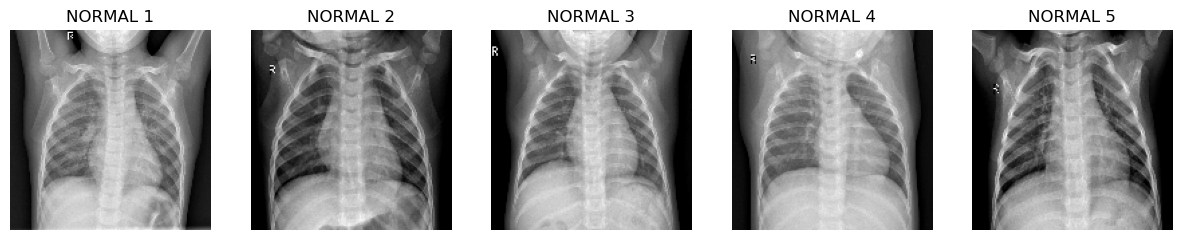

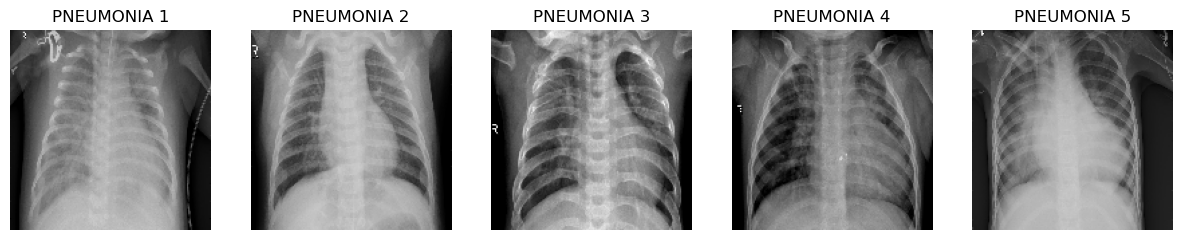

In [12]:
# Display chest X-Ray images
dir = './chest_xray/train'

show_grid_img(dir)

In [13]:
# Access to class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(datagen_flow_train.classes),
    y=datagen_flow_train.classes
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

[Volver a Contenidos](#back)

## Modelado <a id='modeling'></a>

In [59]:
# Creating the CNN model

model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(120, activation='relu'),
    Dropout(0.25),
    Dense(60, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │    61,935,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,943,697 (236.30 MB)

 Trainable params: 61,943,697 (236.30 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Model compilation

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
# Callbacks to stop training if there is no improvement and reduce the learning rate

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


[Volver a Contenidos](#back)

## Entrenamiento del modelo <a id='train'></a>

In [71]:
%%time
history = model.fit(
    datagen_flow_train,
    epochs=25,
    validation_data=datagen_flow_val,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5834 - loss: 0.8330 - val_accuracy: 0.7500 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8208 - loss: 0.4114 - val_accuracy: 0.6250 - val_loss: 0.6285 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8699 - loss: 0.3238 - val_accuracy: 0.7500 - val_loss: 0.3950 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8828 - loss: 0.2857 - val_accuracy: 0.8125 - val_loss: 0.3667 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8763 - loss: 0.2831 - val_accuracy: 0.7500 - val_loss: 0.4703 - learning_rate: 1.0000e-04
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8835 - loss: 0.2720 - val_accuracy: 0.8125 - val_loss: 0.3573 - learning_rate: 1.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - acc

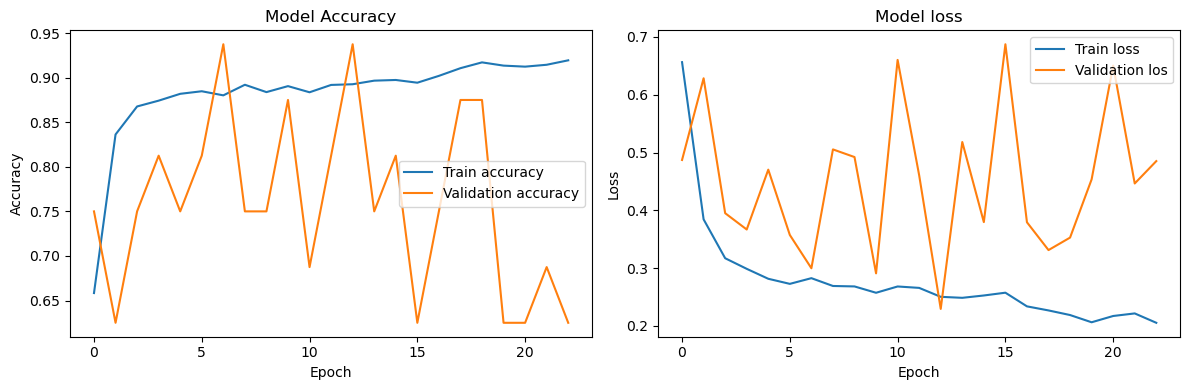

In [95]:
# History of training accuracy values

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# History of training loss values

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation los')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

[Volver a Contenidos](#back)

## Predicción del modelo <a id='predict'></a>

In [98]:
train_loss, train_acc = model.evaluate(datagen_flow_train, batch_size = 16, verbose = 0)

print("Results of the model for training data")
print('Training accuracy:',train_acc*100)
print('Training Loss:',train_loss)

Results of the model for training data
Training accuracy: 87.97929286956787
Training Loss: 0.29407405853271484


In [99]:
test_loss, test_acc = model.evaluate(datagen_flow_test, batch_size = 16, verbose = 0)

print("Results of the model for test data")
print('Test accuracy:',test_acc*100)
print('Test Loss:',test_loss)

Results of the model for test data
Test accuracy: 81.7307710647583
Test Loss: 0.4699200987815857


In [100]:
predictions = model.predict(datagen_flow_test)
y_test = datagen_flow_test.classes
y_predict = (predictions > 0.5).astype(int)

predictions = predictions.reshape(1,-1)[0]
confusion = confusion_matrix(y_test,y_predict)
display(confusion)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step


array([[215,  19],
       [ 95, 295]], dtype=int64)

In [106]:
print(classification_report(y_test, y_predict, target_names=labels.values()))

              precision    recall  f1-score   support

      NORMAL       0.69      0.92      0.79       234
   PNEUMONIA       0.94      0.76      0.84       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.81       624
weighted avg       0.85      0.82      0.82       624



[Volver a Contenidos](#back)

## Conclusión general del proyecto <a id='end'></a>

Este proyecto se enfocó en desarrollar un modelo de aprendizaje profundo utilizando redes neuronales convolucionales (CNNs) para detectar neumonía en imágenes de rayos X, un avance crucial en la intersección de la inteligencia artificial y la salud. El objetivo principal fue crear un sistema capaz de identificar con precisión casos de neumonía, lo que podría ayudar a los profesionales de la salud a mejorar los tiempos de diagnóstico y tomar decisiones más informadas.

El conjunto de datos utilizado consistió en imágenes de rayos X, clasificadas en dos categorías: **Normal** y **Neumonía**. Tras 25 épocas de entrenamiento, el modelo alcanzó una **precisión de 81.7% en el conjunto de prueba** y un **recall de 0.76 para la clase de neumonía**, lo que demuestra su capacidad para identificar correctamente la mayoría de los casos de neumonía. La matriz de confusión mostró un rendimiento sólido, con 295 de 390 casos de neumonía correctamente identificados.

El desarrollo de modelos automatizados para la detección de neumonía es de vital importancia para el sector salud, ya que podría aliviar la carga de trabajo de los radiólogos y mejorar los tiempos de respuesta en hospitales y clínicas, especialmente en regiones con acceso limitado a recursos médicos. Además, la capacidad de integrar tales modelos en sistemas de diagnóstico existentes podría optimizar los procedimientos de atención médica y salvar vidas.

[Volver a Contenidos](#back)